In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import datetime
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=256, n_hidden2=128):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

In [3]:
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.0001, gamma=0.99, seed = 85):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        # np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)

            #### TO DO: Write the equation for delta (TD error)
            ## Write code below
            delta = reward + self.gamma * V_s_next - V_s
            
            V_s_next = tf.stop_gradient(V_s_next)

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

In [4]:
from tqdm.notebook import tqdm_notebook as tqdm
env = gym.make('CartPole-v1')

# print env info
print("Action Space: ", env.action_space)
print("Action Size: ", env.action_space.n)
print(env.reset().reshape(1,-1))


Action Space:  Discrete(2)
Action Size:  2
[[ 0.03983982  0.00531971 -0.01528818 -0.02277896]]


In [17]:

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n)
#Number of episodes
episodes = 1000
tf.compat.v1.reset_default_graph()

reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()

for ep in tqdm(range(1, episodes + 1)):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0
    while not done:
        action = agent.sample_action(state) ##Sample Action
        next_state, reward, done, info = env.step(action) ##Take action
        next_state = next_state.reshape(1,-1)
        ep_rew += reward  ##Updating episode reward
        agent.learn(state, action, reward, next_state, done) ##Update Parameters
        state = next_state ##Updating State
    reward_list.append(ep_rew)
    if(len(reward_list) >= 100):
      avg_100 =  np.mean(reward_list[-100:])
      average_reward_list.append(avg_100)
    else:
      avg = np.mean(reward_list)
      average_reward_list.append(avg)

    if ep % 1 == 0:
        avg_rew = np.mean(reward_list[-1:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > 195.0:
            print('Stopped at Episode ',ep-100)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode  1 Reward 19.000000 Average Reward 19.000000
Episode  2 Reward 18.000000 Average Reward 18.000000
Episode  3 Reward 18.000000 Average Reward 18.000000
Episode  4 Reward 53.000000 Average Reward 53.000000
Episode  5 Reward 36.000000 Average Reward 36.000000
Episode  6 Reward 14.000000 Average Reward 14.000000
Episode  7 Reward 67.000000 Average Reward 67.000000
Episode  8 Reward 28.000000 Average Reward 28.000000
Episode  9 Reward 61.000000 Average Reward 61.000000
Episode  10 Reward 70.000000 Average Reward 70.000000
Episode  11 Reward 18.000000 Average Reward 18.000000
Episode  12 Reward 48.000000 Average Reward 48.000000
Episode  13 Reward 32.000000 Average Reward 32.000000
Episode  14 Reward 162.000000 Average Reward 162.000000
Episode  15 Reward 96.000000 Average Reward 96.000000
Episode  16 Reward 46.000000 Average Reward 46.000000
Episode  17 Reward 98.000000 Average Reward 98.000000
Episode  18 Reward 50.000000 Average Reward 50.000000
Episode  19 Reward 25.000000 Averag

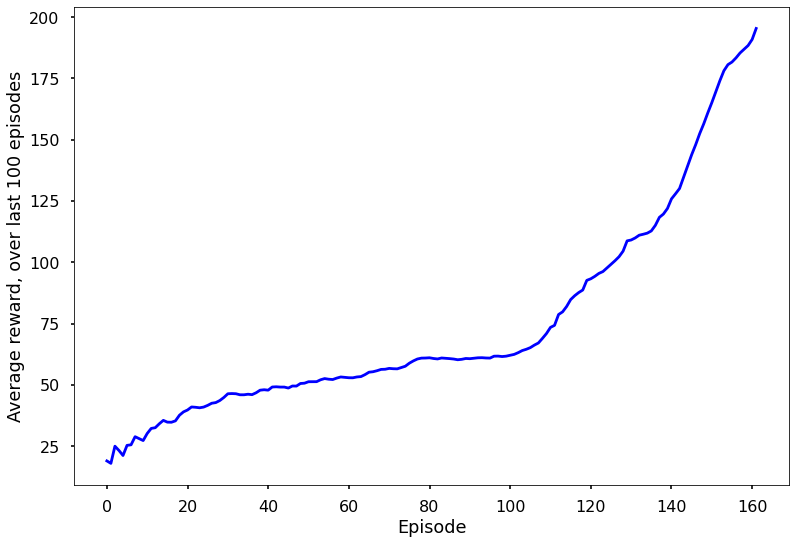

In [14]:
### Plot of total reward vs episode
## Write Code Below

plt.style.use('seaborn-poster')
# plt.figure(figsize = (10,8))
plt.xlabel('Episode')
plt.ylabel('Average reward, over last 100 episodes')
plt.plot(range(len(average_reward_list)),average_reward_list, 'b')
plt.show()


In [5]:
def actor_critic(env, episodes=2000, lr = 1e-4, gamma = 0.99):
    # rs = np.random.RandomState()
    #Initializing Agent
    agent = Agent(lr=lr, gamma=gamma, action_size=env.action_space.n)
    tf.compat.v1.reset_default_graph()

    reward_list = []
    # average_reward_list = []

    for ep in tqdm(range(1, episodes + 1), desc='lr = '+str(lr)):
        state = env.reset().reshape(1,-1)
        done = False
        ep_rew = 0
        while not done:
            action = agent.sample_action(state) ##Sample Action
            next_state, reward, done, info = env.step(action) ##Take action
            next_state = next_state.reshape(1,-1)
            ep_rew += reward  ##Updating episode reward
            agent.learn(state, action, reward, next_state, done) ##Update Parameters
            state = next_state ##Updating State
        reward_list.append(ep_rew)
        # if(len(reward_list) >= 20):
        #     avg_20 =  np.mean(reward_list[-20:])
        #     average_reward_list.append(avg_20)
        # else:
        #     avg = np.mean(reward_list)
        #     average_reward_list.append(avg)

        if ep % 5 == 0:
            avg_rew = np.mean(reward_list[-5:])
            # print('\rEpisode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew, end='')

        # if ep % 20:
        #     avg_20 =  np.mean(reward_list[-20:])
        #     if avg_20 > -100.0:
        #         print('\rStopped at Episode ',ep-20)
        #         break
    return avg_rew, reward_list


lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1000 [00:00<?, ?it/s]

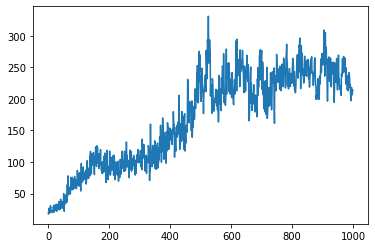

In [6]:
import threading
import queue

my_queue = queue.Queue()

def storeInQueue(f):
  def wrapper(*args):
    my_queue.put(f(*args))
  return wrapper


@storeInQueue
def actor_critic_mt(env,episodes,lr,gamma):
   _, l = actor_critic(env,episodes,lr,gamma)
   return l



# t = threading.Thread(target=get_name, args = ("foo", ))
# t.start()


experiments = 1
episodes = 5000
gamma = 0.99
lr = 1e-4
avg_rew_plots = np.zeros((experiments,episodes))
for e in range(experiments):
    try:
        env = gym.make('CartPole-v1')
        t = threading.Thread(target=actor_critic_mt, args = (env,episodes,lr,gamma))
        t.start()
    except:
        print("threading failed for e = ", e)
        # avg_rew, avg_rew_plots[e] = actor_critic(env, lr = lr,episodes=episodes)
        exit()

for e in range(experiments):
    avg_rew_plots[e] = my_queue.get()
    
avg_avg_rew_plot = np.average(avg_rew_plots, axis=0)
plt.plot(avg_avg_rew_plot)


In [7]:
reward_variance_plot = np.var(avg_rew_plots, axis=0)

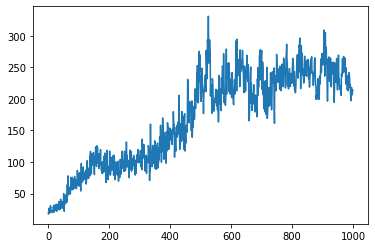

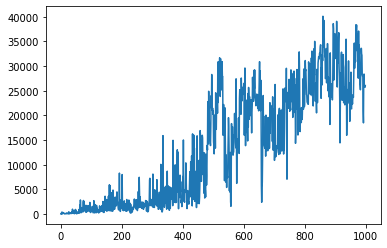

In [8]:
plt.plot(avg_avg_rew_plot)
plt.show()
plt.plot(reward_variance_plot)
plt.show()

C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


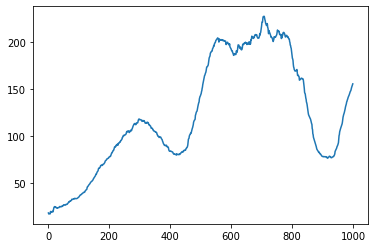

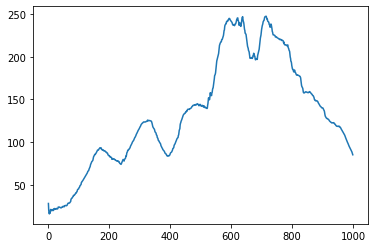

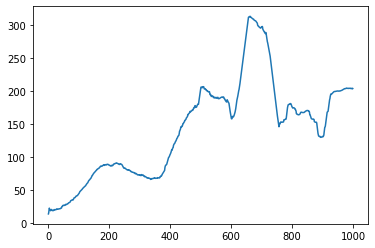

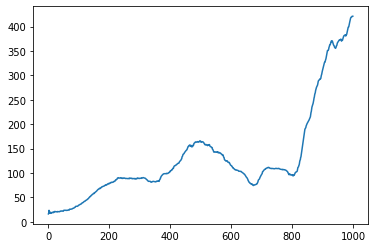

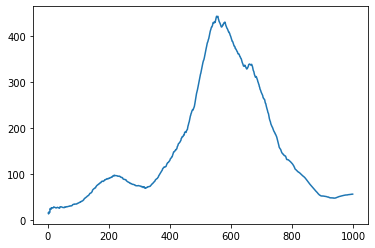

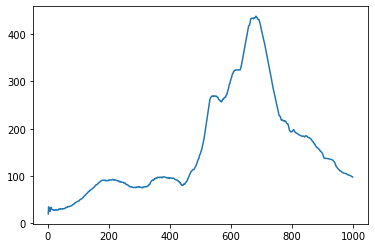

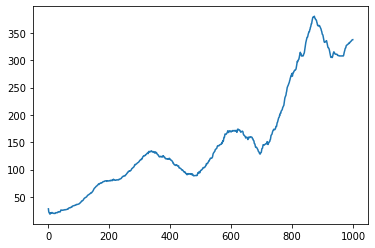

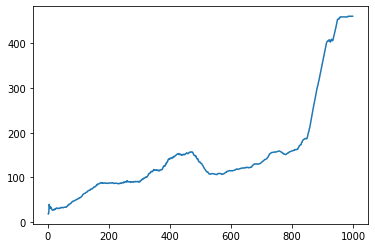

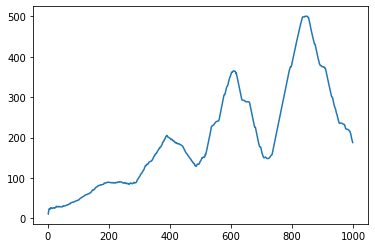

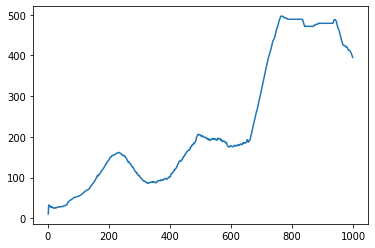

In [10]:
for l in avg_rew_plots:
    plot = []
    for i in range(len(l)):
        if(i < 100):
            plot.append(np.mean(l[:i]))
        else:
            plot.append(np.mean(l[i-100:i]))
    plt.plot(plot)
    plt.show()

C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


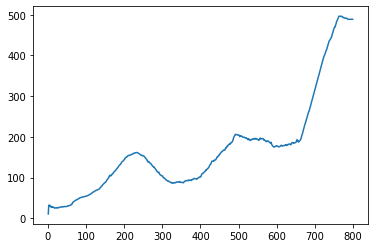

In [12]:
plot = []
for i in range(800):
    if(i < 100):
        plot.append(np.mean(avg_rew_plots[9][:i]))
    else:
        plot.append(np.mean(avg_rew_plots[9][i-100:i]))
plt.plot(plot)
plt.show()

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

lr = 0.0001:   0%|          | 0/1500 [00:00<?, ?it/s]

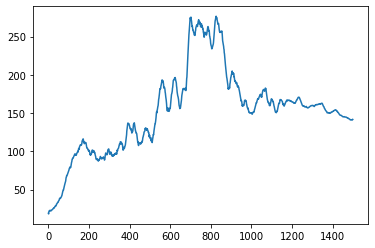

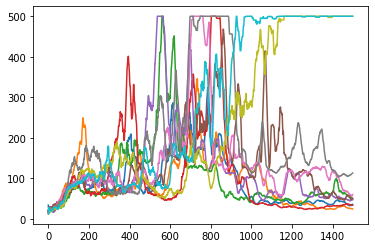

In [9]:
import threading
import queue

my_queue = queue.Queue()

def storeInQueue(f):
  def wrapper(*args):
    my_queue.put(f(*args))
  return wrapper


@storeInQueue
def actor_critic_mt(env,episodes,lr,gamma):
   _, l = actor_critic(env,episodes,lr,gamma)
   return l



# t = threading.Thread(target=get_name, args = ("foo", ))
# t.start()


experiments = 10
episodes = 1500
gamma = 0.99
lr = 1e-4
avg_rew_plots = np.zeros((experiments,episodes))
for e in range(experiments):
    try:
        env = gym.make('CartPole-v1')
        t = threading.Thread(target=actor_critic_mt, args = (env,episodes,lr,gamma))
        t.start()
    except:
        print("threading failed for e = ", e)
        # avg_rew, avg_rew_plots[e] = actor_critic(env, lr = lr,episodes=episodes)
        exit()

for e in range(experiments):
    avg_rew_plots[e] = my_queue.get()
    
avg_avg_rew_plot = np.average(avg_rew_plots, axis=0)
plt.plot(avg_avg_rew_plot)
plt.show()

for l in avg_rew_plots:
  plt.plot(l)
plt.show()

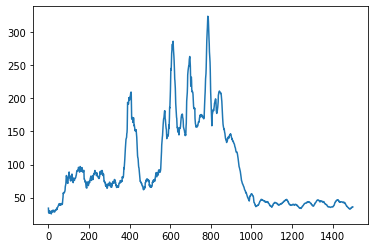

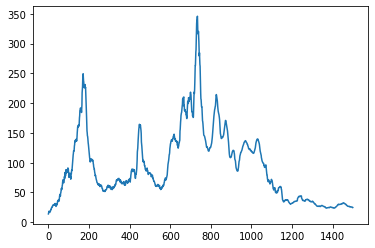

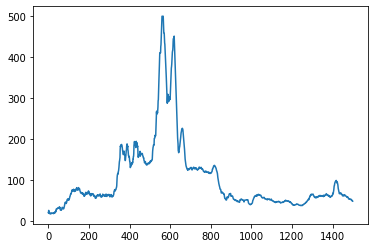

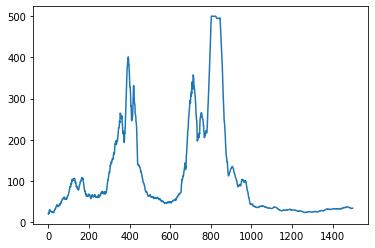

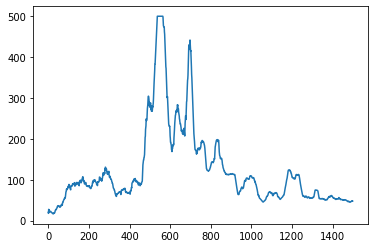

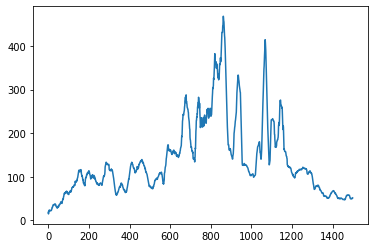

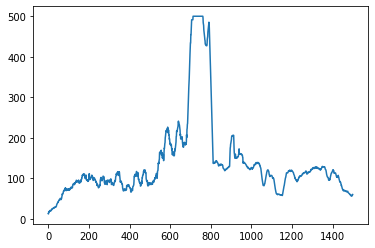

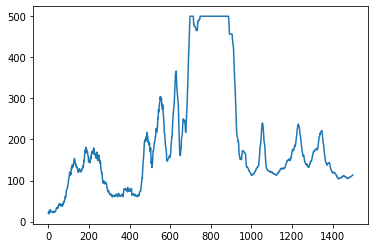

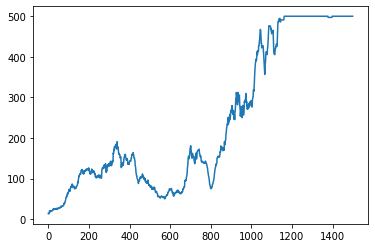

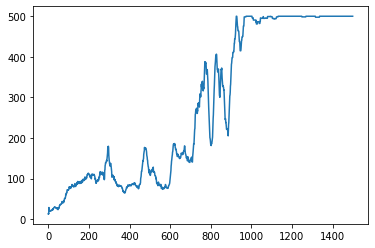

In [10]:
for l in avg_rew_plots:
    plt.plot(l)
    plt.show()